In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.animation as animation
import warnings

warnings.filterwarnings('ignore')

<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Data Preparation
</h2>

In [2]:
# Loading Train Data
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [3]:
# Correcting specific mean pressure value
df.loc[df.index == '2016-03-28', 'meanpressure'] = np.nan
df['meanpressure'].fillna(method='backfill', inplace=True)

In [4]:
# Data Preparation
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear

In [5]:
# Convert to cyclical features (fourier)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [6]:
# Additional Lag Features
for lag in range(1,4):
    df[f'temp_lag_{lag}'] = df['meantemp'].shift(lag)

df.dropna(inplace=True)

<Axes: >

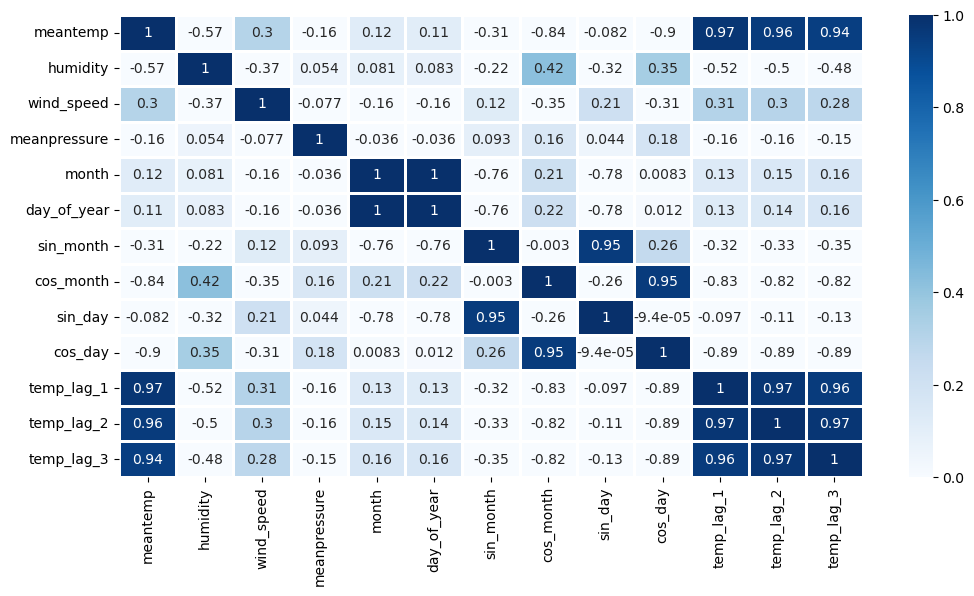

In [41]:
pear_corr = df.corr(method='pearson')
plt.figure(figsize=(12,6), dpi=100)
sns.heatmap(pear_corr, cmap='Blues', annot=True, linewidths=1, vmin=0)

<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Data Preprocessing
</h2>

In [8]:
# Normalization and Data Splitting
X = df.drop('meantemp', axis=1)
y = df['meantemp']

# Splitting the Data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [9]:
# Normalize the features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))

In [10]:
# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Model Preparation
</h2>

In [11]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])
        return out

In [12]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[2]  # Number of features
hidden_dim = 100  # Number of LSTM units
output_dim = 1  # Single output for regression
num_layers = 3  # Number of LSTM layers
dropout_prob = 0.2  # Dropout probability

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Model summary
model

LSTMModel(
  (lstm): LSTM(12, 100, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [14]:
# Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(torch.from_numpy(X_train).float())
    loss = criterion(y_pred, torch.from_numpy(y_train).float())
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        val_pred = model(torch.from_numpy(X_val).float()).detach().numpy()
        val_loss = mean_squared_error(y_val, val_pred)
        print(f'Epoch {epoch}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss}')

Epoch 0/200, Train Loss: 0.49717387557029724, Val Loss: 0.4463745869475548
Epoch 10/200, Train Loss: 0.37140780687332153, Val Loss: 0.322770332528055
Epoch 20/200, Train Loss: 0.16235420107841492, Val Loss: 0.12177293578860354
Epoch 30/200, Train Loss: 0.08728518337011337, Val Loss: 0.10254939565322346
Epoch 40/200, Train Loss: 0.047694262117147446, Val Loss: 0.047752233295709316
Epoch 50/200, Train Loss: 0.03942606970667839, Val Loss: 0.039788631629457734
Epoch 60/200, Train Loss: 0.032845061272382736, Val Loss: 0.035530944313128705
Epoch 70/200, Train Loss: 0.023628024384379387, Val Loss: 0.025007210187123628
Epoch 80/200, Train Loss: 0.01643672026693821, Val Loss: 0.018284858208873996
Epoch 90/200, Train Loss: 0.010341000743210316, Val Loss: 0.010347353529670351
Epoch 100/200, Train Loss: 0.00704122195020318, Val Loss: 0.007639336615988487
Epoch 110/200, Train Loss: 0.005821951664984226, Val Loss: 0.0062768291708004695
Epoch 120/200, Train Loss: 0.005816211458295584, Val Loss: 0.005

<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Model Prediction
</h2>

In [15]:
# Model Prediction
test = pd.read_csv('DailyDelhiClimateTest.csv')
test['date'] = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)

In [16]:
# Correcting specific mean pressure value
test.loc[test.index == '2017-01-01', 'meanpressure'] = np.nan
test['meanpressure'].fillna(method='backfill', inplace=True)

In [17]:
# Data Preparation
test['month'] = test.index.month
test['day_of_year'] = test.index.dayofyear

In [18]:
# Convert to cyclical features
test['sin_month'] = np.sin(2 * np.pi * test['month'] / 12)
test['cos_month'] = np.cos(2 * np.pi * test['month'] / 12)
test['sin_day'] = np.sin(2 * np.pi * test['day_of_year'] / 365)
test['cos_day'] = np.cos(2 * np.pi * test['day_of_year'] / 365)

In [19]:
# Additional Lag Features for Test Data
for lag in range(1, 4):
    test[f'temp_lag_{lag}'] = test['meantemp'].shift(lag)

test.dropna(inplace=True)

In [20]:
y_test = test['meantemp']
X_test = test.drop('meantemp', axis=1)

# Normalize the test features
X_test = scaler_X.transform(X_test)

In [21]:
# Reshape data for LSTM
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [22]:
# LSTM Prediction
model.eval()
with torch.no_grad():
    y_pred_lstm = model(torch.from_numpy(X_test).float()).numpy()
    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)

In [23]:
# Evaluate predictions
mse_value = mean_squared_error(y_test, y_pred_lstm)
r2_value = r2_score(y_test, y_pred_lstm)
print('MSE: ', mse_value)
print('R²: ', r2_value)

MSE:  4.085565995849555
R²:  0.8993143444620155


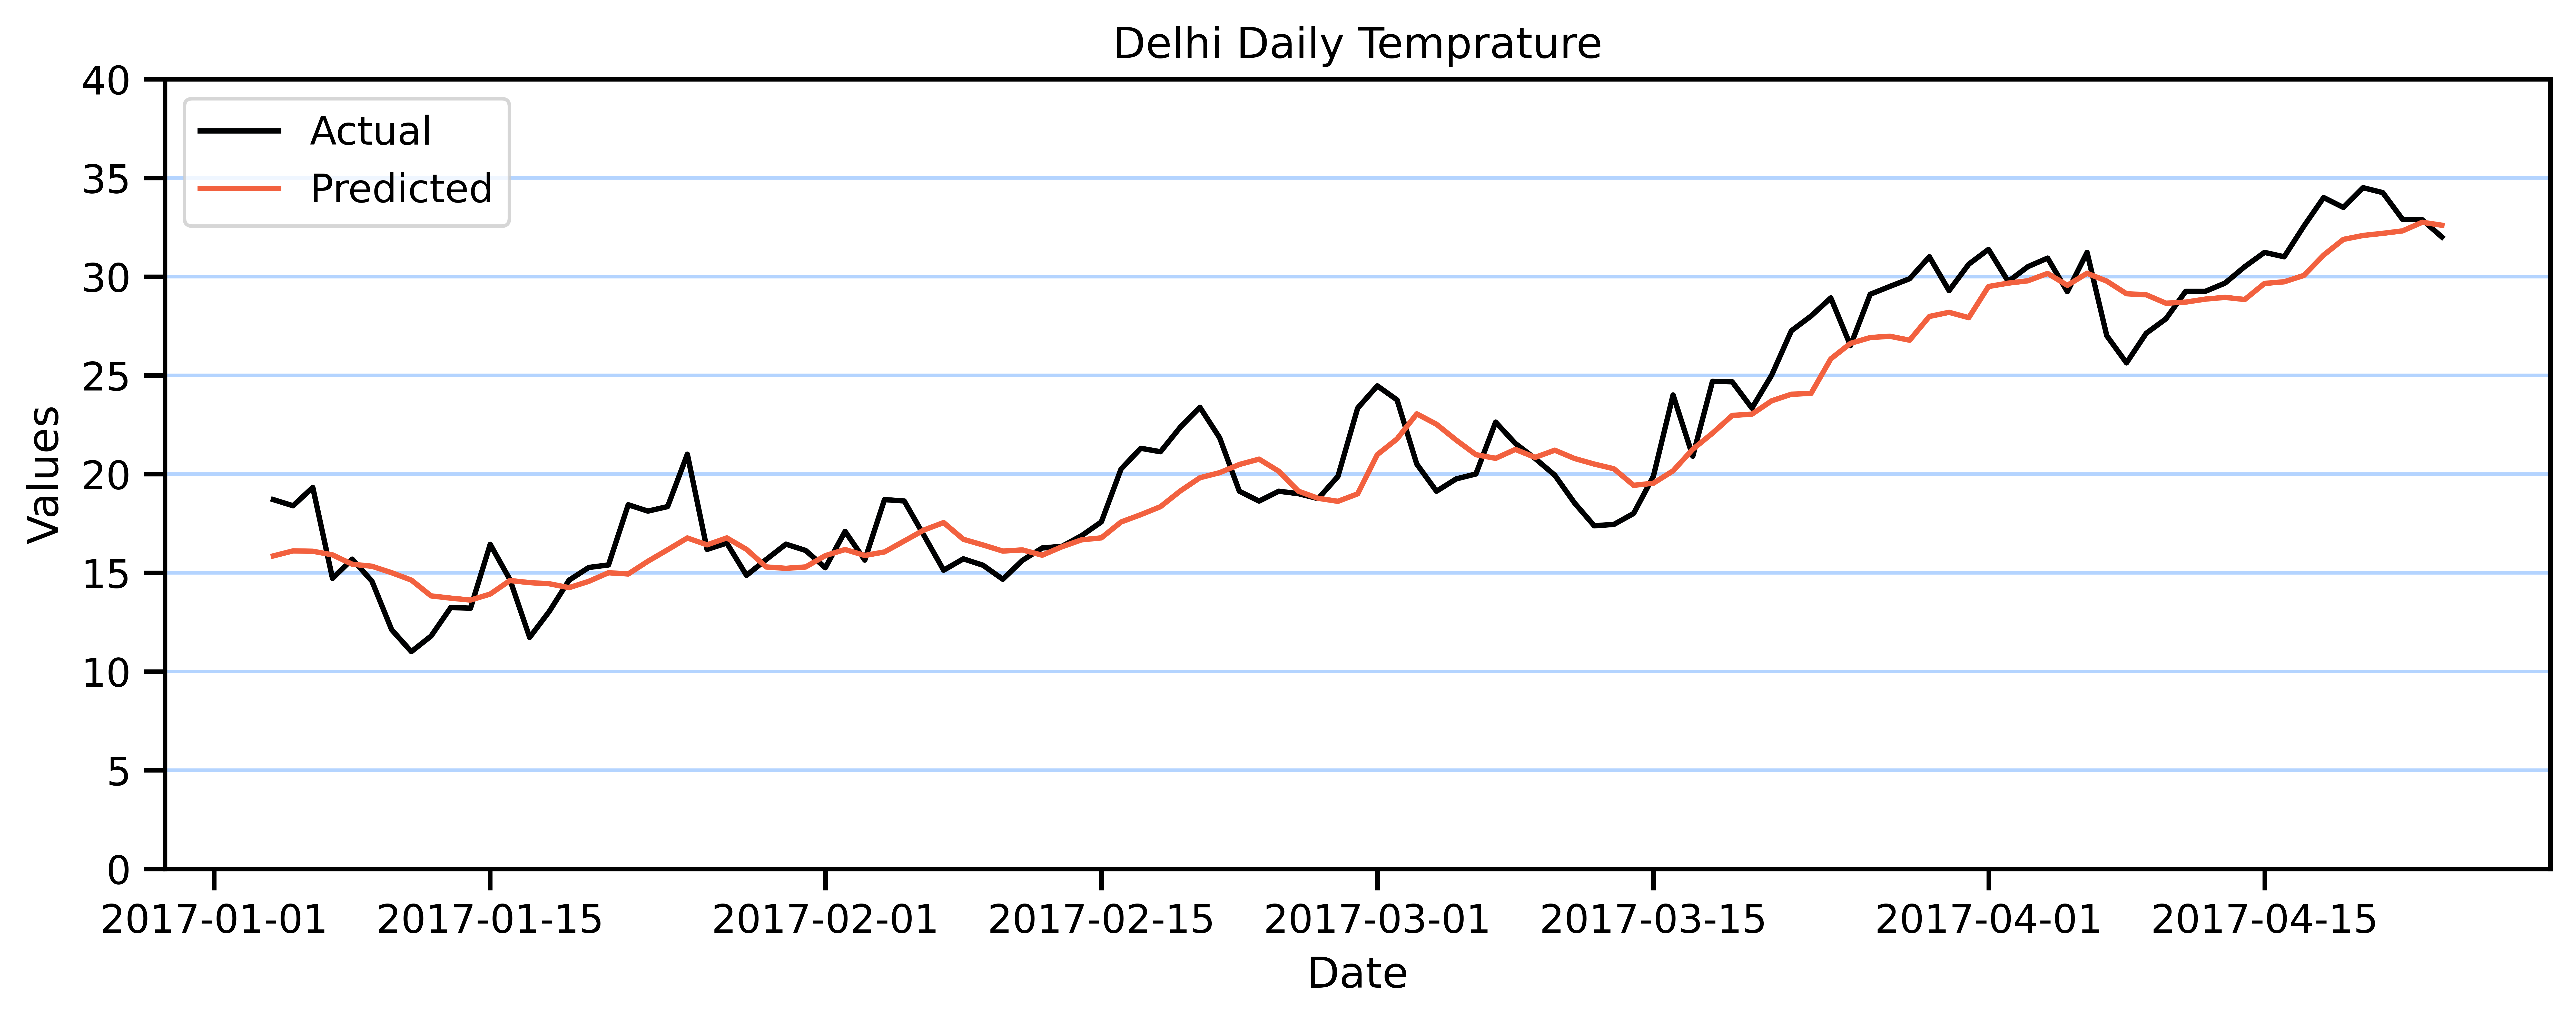

In [85]:
# Create a DataFrame for Actual vs Predicted values
visual = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_lstm.flatten()}, index=test.index)
visual['Month'] = visual.index.month

sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=1000)
plt.grid(visible=True, axis='y', color='#B4D4FF')
plt.ylim(0, 40)

sns.lineplot(data=visual, x=visual.index, y='Actual', label='Actual', color='#000102')
sns.lineplot(data=visual, x=visual.index, y='Predicted', label='Predicted', color='#F2613F')

plt.title('Delhi Daily Temprature')
plt.xlabel('Date')
plt.ylabel('Values')

plt.show()